
###  1. Business Understanding

We have been provided with Airbnb data set for analysis. This dataset comprises of calendar.csv , listings.csv and reviews.csv . However we will be concentrating on analysing only calendar and listings dataset.


In the following section we will try to address and provide information for following queries :-

* What is the most busiest time of the year?
* What is the average price per month in 2016 year?
* Does Price affect rating given by users?
* Does Price affect host response rate?
* What is the correlation of different features with price?

In [ ]:
#Airbnb Seattle Data Analysis

In [51]:
###Importing necessary Libraries

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import custom_lib as t
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

### 2. Data Understanding 
* Listings and Calendar have one to may relationship
* All price columns datatype needs to be change to numeric - Calendar and Listings
* In Calendar dataset we need to add more columns like year, month for data visualiation
* Listings dataset has 91 columns, and we need to extract only those which influence price - 
  for example :- id, host_response_time, host_response_rate, accommodates, bathrooms, bedrooms, beds, price,         weekly_price, monthly_price, cleaning_fee etc ...
* Listings and Reviews also have one to many relationship
* For our business questions we may not even require Reviews dataframe

In [ ]:
###Reading the Calendar CSV files
calendar =pd.read_csv('./calendar_sealte.csv')
calendar.head()

Reading the Listing CSV files

In [ ]:
###Reading the Listing CSV files
listing = pd.read_csv('./listings_sealte.csv')
listing.head()

### 3. Cleansing Data from Calendar CSV
"""
Removing $ from price column.
Instead of dropping the NAN values but calculate the mean of price value for more accurate results.
We will convert listing_id to string so it doesnt interfere with metric columns.
We will group data into year , month and date columns for analysis.
Convert date column from object to date
"""


In [66]:
"""
Removing $ from price column.
Instead of dropping the NAN values but calculate the mean of price value for more accurate results.
We will convert listing_id to string so it doesnt interfere with metric columns.
We will group data into year , month and date columns for analysis.
Convert date column from object to date
"""
#remove_dollar = (lambda x :x.replace('$','') if type(x) is str else x)
#replace_decimal = (lambda x:x[:-3].replace(',','.') if type(x) is str else x)


#calendar['price'] = calendar.price.apply(replace_decimal)
calendar['price'] = calendar.price.apply(lambda x: t.clean_price(x))
calendar['price'] = calendar['price'].astype(float)
calendar['price'].fillna(0,inplace=True)
calendar['listing_id'] = calendar.listing_id.astype(str)
calendar['date'] = pd.to_datetime(calendar['date'])

### Adding Columns date month and year 
calendar['month'] = pd.DatetimeIndex(calendar['date']).month
calendar['year'] = pd.DatetimeIndex(calendar['date']).year
calendar['date']= pd.DatetimeIndex(calendar['date']).date
calendar['month_year'] = pd.to_datetime(calendar['date']).dt.to_period('M')

calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype    
---  ------      --------------    -----    
 0   listing_id  1393570 non-null  object   
 1   date        1393570 non-null  object   
 2   available   1393570 non-null  object   
 3   price       1393570 non-null  float64  
 4   month       1393570 non-null  int64    
 5   year        1393570 non-null  int64    
 6   month_year  1393570 non-null  period[M]
dtypes: float64(1), int64(2), object(3), period[M](1)
memory usage: 74.4+ MB


In [67]:
calendar.head()

,listing_id,date,available,price,month,year,month_year
0,241032,2016-01-04,t,85.0,1,2016,2016-01
1,241032,2016-01-05,t,85.0,1,2016,2016-01
2,241032,2016-01-06,f,0.0,1,2016,2016-01
3,241032,2016-01-07,f,0.0,1,2016,2016-01
4,241032,2016-01-08,f,0.0,1,2016,2016-01


Cleaning Up Listings CSV

In [58]:
"""
After cleaning the calendar CSV we will now perform cleanup of listing csv.
1. Listing CSV has 91 columns
2. We need to remove "," ,"$" and replace Nan values with mean for various columns like weekly_price,monthly_price,security_deposit,cleaning fee etc..
3. This is a humagous dataset and not all columns are required for our analysis so lets create a new dataframe with only specific columns.
4. For host_response_rate and review_scores_rating convert percentage to float.
5. Impute mode value for bathrooms ,beds etc
"""
listings_subset = listing[['id', 'host_response_time', 'host_response_rate','host_acceptance_rate', 'accommodates', 'bathrooms', 
                               'bedrooms', 'beds', 'price', 'weekly_price', 'monthly_price', 'security_deposit','cleaning_fee',
                              'extra_people', 'minimum_nights', 'review_scores_rating', 'instant_bookable', 'zipcode']]


In [59]:
listings_subset.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,minimum_nights,review_scores_rating,instant_bookable,zipcode
0,241032,within a few hours,96%,100%,4,1.0,1.0,1.0,$85.00,NaN,NaN,NaN,NaN,$5.00,1,95.0,f,98119
1,953595,within an hour,98%,100%,4,1.0,1.0,1.0,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00,2,96.0,f,98119
2,3308979,within a few hours,67%,100%,11,4.5,5.0,7.0,$975.00,NaN,NaN,"$1,000.00",$300.00,$25.00,4,97.0,f,98119
3,7421966,NaN,NaN,NaN,3,1.0,0.0,2.0,$100.00,$650.00,"$2,300.00",NaN,NaN,$0.00,1,NaN,f,98119
4,278830,within an hour,100%,NaN,6,2.0,3.0,3.0,$450.00,NaN,NaN,$700.00,$125.00,$15.00,1,92.0,f,98119


In [60]:
"""
Creating function in Lamda to fill NAN values for those Columns with MODE Value
 
"""
fill_with_mode = lambda col:col.fillna(col.mode()[0])
listings_subset[['beds', 'bathrooms', 'bedrooms','id']] = listings_subset[['beds', 'bathrooms', 'bedrooms','id']].apply(fill_with_mode, axis=0)

In [61]:
listings_subset.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,minimum_nights,review_scores_rating,instant_bookable,zipcode
0,241032,within a few hours,96%,100%,4,1.0,1.0,1.0,$85.00,NaN,NaN,NaN,NaN,$5.00,1,95.0,f,98119
1,953595,within an hour,98%,100%,4,1.0,1.0,1.0,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00,2,96.0,f,98119
2,3308979,within a few hours,67%,100%,11,4.5,5.0,7.0,$975.00,NaN,NaN,"$1,000.00",$300.00,$25.00,4,97.0,f,98119
3,7421966,NaN,NaN,NaN,3,1.0,0.0,2.0,$100.00,$650.00,"$2,300.00",NaN,NaN,$0.00,1,NaN,f,98119
4,278830,within an hour,100%,NaN,6,2.0,3.0,3.0,$450.00,NaN,NaN,$700.00,$125.00,$15.00,1,92.0,f,98119


In [62]:
"""
Appying replace decimal and remove dollar for listing subset data and imputing the data.
"""
listings_subset['id'] = listings_subset['id'].astype(str)

listings_subset['price'] = listings_subset.price.apply(replace_decimal)
listings_subset['price'] = listings_subset.price.apply(remove_dollar)
listings_subset['price'] = listings_subset.price.astype(float)

listings_subset['weekly_price'] = listings_subset.weekly_price.apply(replace_decimal)
listings_subset['weekly_price'] = listings_subset.weekly_price.apply(remove_dollar)
listings_subset['weekly_price'] = listings_subset['weekly_price'].astype(float)
listings_subset['weekly_price'].fillna(0, inplace=True)

listings_subset['monthly_price'] = listings_subset.monthly_price.apply(replace_decimal)
listings_subset['monthly_price'] = listings_subset.monthly_price.apply(remove_dollar)
listings_subset['monthly_price'] = listings_subset['monthly_price'].astype(float)
listings_subset['monthly_price'].fillna(0, inplace=True)


listings_subset['security_deposit'] = listings_subset.security_deposit.apply(replace_decimal)
listings_subset['security_deposit'] = listings_subset.security_deposit.apply(remove_dollar)
listings_subset['security_deposit'] = listings_subset['security_deposit'].astype(float)
listings_subset['security_deposit'].fillna(0, inplace=True)

listings_subset['cleaning_fee'] = listings_subset.cleaning_fee.apply(replace_decimal)
listings_subset['cleaning_fee'] = listings_subset.cleaning_fee.apply(remove_dollar)
listings_subset['cleaning_fee'] = listings_subset['cleaning_fee'].astype(float)
listings_subset['cleaning_fee'].fillna(0, inplace=True)

listings_subset['extra_people'] = listings_subset.extra_people.apply(replace_decimal)
listings_subset['extra_people'] = listings_subset.extra_people.apply(remove_dollar)
listings_subset['extra_people'] = listings_subset['extra_people'].astype(float)

In [63]:
listings_subset.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,minimum_nights,review_scores_rating,instant_bookable,zipcode
0,241032,within a few hours,96%,100%,4,1.0,1.0,1.0,85.0,0.0,0.0,0.0,0.0,5.0,1,95.0,f,98119
1,953595,within an hour,98%,100%,4,1.0,1.0,1.0,150.0,1.0,3.0,100.0,40.0,0.0,2,96.0,f,98119
2,3308979,within a few hours,67%,100%,11,4.5,5.0,7.0,975.0,0.0,0.0,1.0,300.0,25.0,4,97.0,f,98119
3,7421966,NaN,NaN,NaN,3,1.0,0.0,2.0,100.0,650.0,2.3,0.0,0.0,0.0,1,NaN,f,98119
4,278830,within an hour,100%,NaN,6,2.0,3.0,3.0,450.0,0.0,0.0,700.0,125.0,15.0,1,92.0,f,98119


In [64]:
listings_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3818 non-null   object 
 1   host_response_time    3295 non-null   object 
 2   host_response_rate    3295 non-null   object 
 3   host_acceptance_rate  3045 non-null   object 
 4   accommodates          3818 non-null   int64  
 5   bathrooms             3818 non-null   float64
 6   bedrooms              3818 non-null   float64
 7   beds                  3818 non-null   float64
 8   price                 3818 non-null   float64
 9   weekly_price          3818 non-null   float64
 10  monthly_price         3818 non-null   float64
 11  security_deposit      3818 non-null   float64
 12  cleaning_fee          3818 non-null   float64
 13  extra_people          3818 non-null   float64
 14  minimum_nights        3818 non-null   int64  
 15  review_scores_rating 

In [65]:
""" Convert Percentage values to float"""
listings_subset['host_response_rate'] = listings_subset.host_response_rate.apply(lambda x: t.clean_perc(x))
listings_subset.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,minimum_nights,review_scores_rating,instant_bookable,zipcode
0,241032,within a few hours,0.96,100%,4,1.0,1.0,1.0,85.0,0.0,0.0,0.0,0.0,5.0,1,95.0,f,98119
1,953595,within an hour,0.98,100%,4,1.0,1.0,1.0,150.0,1.0,3.0,100.0,40.0,0.0,2,96.0,f,98119
2,3308979,within a few hours,0.67,100%,11,4.5,5.0,7.0,975.0,0.0,0.0,1.0,300.0,25.0,4,97.0,f,98119
3,7421966,NaN,NaN,NaN,3,1.0,0.0,2.0,100.0,650.0,2.3,0.0,0.0,0.0,1,NaN,f,98119
4,278830,within an hour,1.00,NaN,6,2.0,3.0,3.0,450.0,0.0,0.0,700.0,125.0,15.0,1,92.0,f,98119


### 4. Data Modelling and Results of AirBnB data 

"""
In this section we will perform data modelling and share the results for Airbnb Seattle data.
We will address our 5 questions mentioned earlier and try to share insights for same.
"""

### What is the most busiest time of the year?

In [68]:
calendar.head()

,listing_id,date,available,price,month,year,month_year
0,241032,2016-01-04,t,85.0,1,2016,2016-01
1,241032,2016-01-05,t,85.0,1,2016,2016-01
2,241032,2016-01-06,f,0.0,1,2016,2016-01
3,241032,2016-01-07,f,0.0,1,2016,2016-01
4,241032,2016-01-08,f,0.0,1,2016,2016-01


In [69]:
calendar_2016 = calendar[calendar.year ==2016]

In [ ]:
"""
Bar Diagram to depict the busiest time of the year.
"""
busy_time = calendar_2016.groupby('month')['price'].mean()
busy_time.plot(kind ='barh',figsize =(20,15), colormap="Dark2");

No wonder December is the most busiest time of the year with Xmas and New year being around!! Second most busiest month is June.

### What is the average price per month in 2016 year?

In [ ]:
"""
Analyze the price over period of time
"""
sns.barplot(data = calendar_2016, x ='month', y = 'price')
plt.ylabel('Average price')
plt.xlabel('Months')
plt.title('Average price per month');
plt.axhline(calendar_2016.price.mean(), linestyle='--', color='red');

calendar_2016.price.mean()

91.881 is the average price per month

In [ ]:
listings_subset.head()

### Does Price affect rating given by users?



In [ ]:
price_users = listings_subset.groupby('review_scores_rating')['price'].mean()

In [ ]:
price_users.plot(kind ='barh',figsize =(20,15), colormap="Dark2");

No from below bar graph we can see that price doesnt affect rating given by user.

### Does Price affect host response rate?

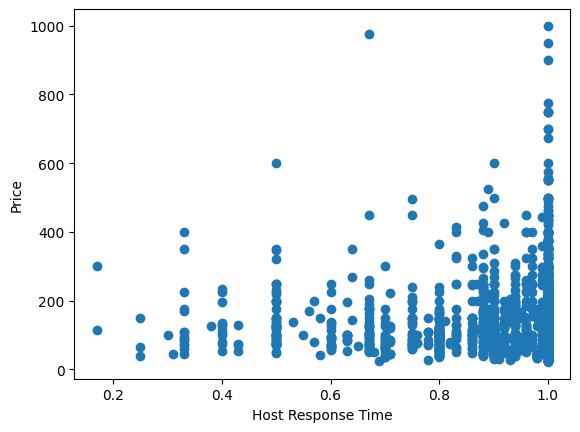

In [70]:
"""
Scatter Plot to depict host response rate.
"""
price_users = listings_subset['host_response_rate']
price_mean = listings_subset['price']
plt.xlabel("Host Response Time")
plt.ylabel("Price")
plt.scatter(price_users, price_mean)
plt.show()

The scatter plot shows host response rate affects price. Lower priced listing hosts respond quicker.

### What is the correlation of different features with price?

In [71]:
listings_subset.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,minimum_nights,review_scores_rating,instant_bookable,zipcode
0,241032,within a few hours,0.96,100%,4,1.0,1.0,1.0,85.0,0.0,0.0,0.0,0.0,5.0,1,95.0,f,98119
1,953595,within an hour,0.98,100%,4,1.0,1.0,1.0,150.0,1.0,3.0,100.0,40.0,0.0,2,96.0,f,98119
2,3308979,within a few hours,0.67,100%,11,4.5,5.0,7.0,975.0,0.0,0.0,1.0,300.0,25.0,4,97.0,f,98119
3,7421966,NaN,NaN,NaN,3,1.0,0.0,2.0,100.0,650.0,2.3,0.0,0.0,0.0,1,NaN,f,98119
4,278830,within an hour,1.00,NaN,6,2.0,3.0,3.0,450.0,0.0,0.0,700.0,125.0,15.0,1,92.0,f,98119


C:\Users\mdmal\AppData\Local\Temp\ipykernel_14904\2408976403.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  listing_corr = listings_subset.corr()


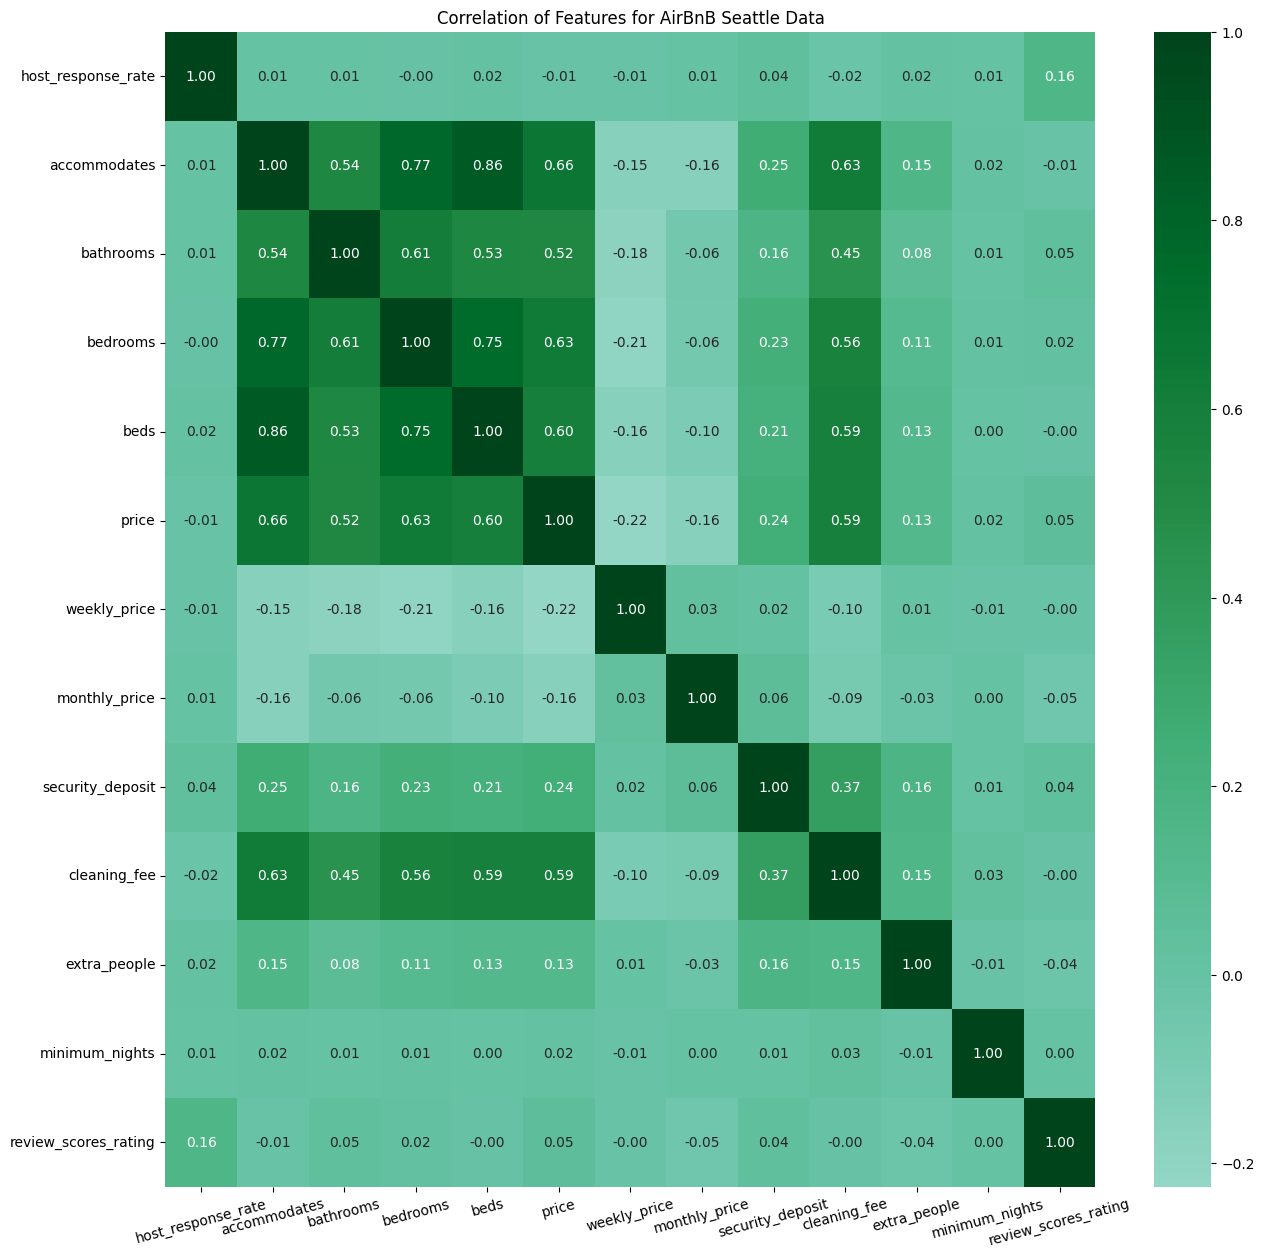

In [72]:
"""
Finding the correlation of different features with price
"""
listing_corr = listings_subset.corr()

kot = listing_corr[listing_corr.apply(lambda x: abs(x)>=0)]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(kot, annot = True, fmt='.2f', cmap = 'BuGn', center = 0, ax=ax)
plt.title('Correlation of Features for AirBnB Seattle Data');
plt.xticks(rotation = 15);
